<a href="https://colab.research.google.com/github/iamgus123/dl19/blob/main/project/cifar10/cifar10_DL3A_TL_tf_datasets_EfficientNetB1_ConvNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning
- cifar10 dataset from tensorflow_datasets
- ConvNet: EfficientNetB1

> https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB1

In [1]:
# import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

tf.__version__

'2.12.0'

## Load cifar10 using tensorflow_datasets

In [2]:
# CFAR-10 데이터 세트를 적재한다. (tensorflow_datasets)
import tensorflow_datasets as tfds

Batch_size = 64
# 
dataset_name = "cifar10"  # change the name of the dataset 
# PrefetchDataset : BatchDataSet => (None, 32, 32, 3)
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, 
    split=["train", "test"], 
    with_info=True, 
    batch_size=Batch_size,  # preset mini-batch
    as_supervised=True
)

NUM_CLASSES = ds_info.features["label"].num_classes
print(NUM_CLASSES)
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print(ds_train)  # PrefetchDataset
# PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3)
# Batch preset?

for i, (image, label) in enumerate(ds_train.take(1)):
    print(i, image.shape, label)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteE6HZXN/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteE6HZXN/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
10
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
0 (64, 32, 32, 3) tf.Tensor(
[7 8 4 4 6 5 2 9 6 6 9 9 3 0 8 7 9 0 4 9 0 8 6 4 2 8 8 7 0 8 4 2 3 7 0 5 4
 3 8 1 5 9 4 9 8 6 9 7 7 7 3 6 3 8 3 6 1 1 7 0 9 0 0 4], shape=(64,), dtype=int64)


In [3]:
print(ds_train)
print(ds_info)
ds_info.features

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path=PosixGPath('/tmp/tmpm429z4lhtfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=5

FeaturesDict({
    'id': Text(shape=(), dtype=string),
    'image': Image(shape=(32, 32, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})

In [4]:
# Show samples
# _ = tfds.show_examples(ds_train, ds_info)
IMG_SIZE = 128 #120 #240  # for Transfer Learning using EfficientNetB1
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

print(len(ds_train),len(ds_test))

str(ds_train)  # MapDataset
for i, (image, label) in enumerate(ds_train.take(1)):
    print(i, image.shape, label)


782 157
0 (64, 128, 128, 3) tf.Tensor(
[7 8 4 4 6 5 2 9 6 6 9 9 3 0 8 7 9 0 4 9 0 8 6 4 2 8 8 7 0 8 4 2 3 7 0 5 4
 3 8 1 5 9 4 9 8 6 9 7 7 7 3 6 3 8 3 6 1 1 7 0 9 0 0 4], shape=(64,), dtype=int64)


In [5]:
50000/64,10000/64

(781.25, 156.25)

In [6]:
str(ds_train)

'<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>'

========================= Train dataset =========================
(64, 128, 128, 3)


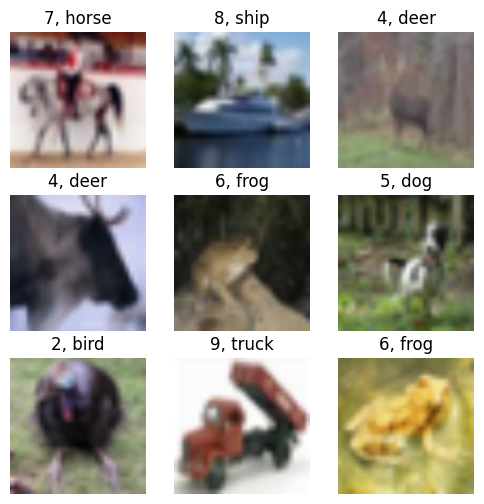

========================= Test dataset =========================


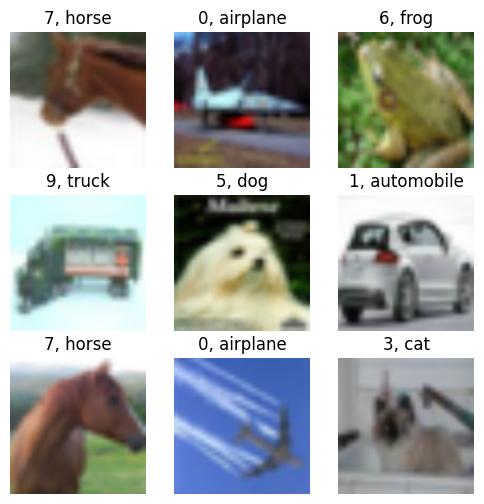

In [7]:
#
# Visualizing the dataset
#
# The following code shows the first 9 images with their labels.

print("="*25, 'Train dataset', "="*25)
# figure 크기를 조절합니다.
plt.figure(figsize=(6, 6))
# 배치 하나를 가져옵니다.
for images, labels in ds_train.take(1):    # Make a batch of images & labels
    print(images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # tensor2numpy array: tensor.numpy()
        # plt.title(label_names[int(labels[i])])
        plt.title(str(labels[i].numpy()) + ", " + label_names[int(labels[i])])
        plt.axis("off")
plt.show()

print("="*25, 'Test dataset', "="*25)

plt.figure(figsize=(6, 6))
for images, labels in ds_test.take(1):    # Make a batch of images & labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(label_names[int(labels[i])])
        plt.title(str(labels[i].numpy()) + ", " + label_names[int(labels[i])])
        plt.axis("off")
plt.show()


## Data augmentation

tf.Tensor(
[7 8 4 4 6 5 2 9 6 6 9 9 3 0 8 7 9 0 4 9 0 8 6 4 2 8 8 7 0 8 4 2 3 7 0 5 4
 3 8 1 5 9 4 9 8 6 9 7 7 7 3 6 3 8 3 6 1 1 7 0 9 0 0 4], shape=(64,), dtype=int64) (64, 128, 128, 3)
(1, 124, 123, 3)
(1, 139, 134, 3)
(1, 118, 124, 3)
(1, 131, 123, 3)
(1, 122, 134, 3)
(1, 130, 119, 3)
(1, 140, 126, 3)
(1, 139, 118, 3)
(1, 121, 137, 3)


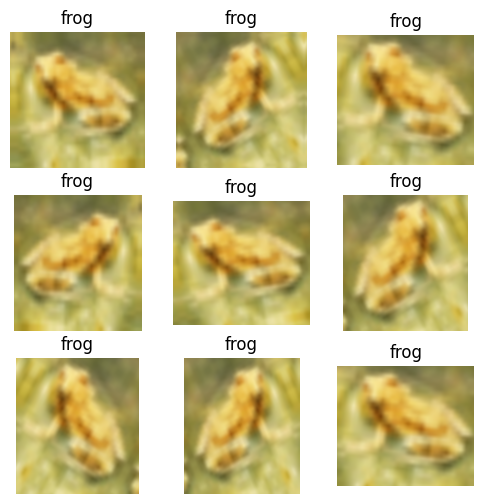

tf.Tensor(
[7 0 6 9 5 1 7 0 3 2 7 2 7 9 6 8 8 8 7 9 4 2 3 5 0 0 2 8 1 8 2 0 7 2 0 0 9
 1 0 5 1 5 0 3 5 0 2 0 5 3 7 4 1 4 2 5 1 5 2 0 7 2 2 1], shape=(64,), dtype=int64) (64, 128, 128, 3)
(1, 119, 129, 3)
(1, 126, 117, 3)
(1, 136, 123, 3)
(1, 126, 137, 3)
(1, 128, 125, 3)
(1, 134, 118, 3)
(1, 122, 126, 3)
(1, 138, 119, 3)
(1, 122, 115, 3)


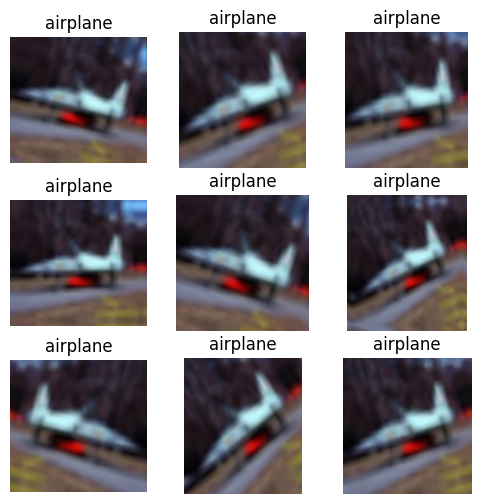

In [8]:
#
# Data augmentation
#
from tensorflow.keras import layers
tf.get_logger().setLevel('ERROR')  # Clear warnings in data augmentation
# Create a data augmentation with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(factor=0.1),
  layers.RandomZoom(0.1),
  # layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  layers.RandomHeight(0.1),
  layers.RandomWidth(0.1),
  # layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# Plot the augmented images
plt.figure(figsize=(6,6))
image_idx = np.random.randint(10)   # 0~ 9
for images, labels in ds_train.take(1):    # Make a batch of images & labels
    print(labels,images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = data_augmentation(tf.expand_dims(images[image_idx], axis=0))
        print(aug_img.shape)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(label_names[labels[image_idx]]))
        plt.axis("off")
    break
plt.show()

plt.figure(figsize=(6,6))
image_idx = np.random.randint(10)   # 0~ 9
for images, labels in ds_test.take(1):    # Make a batch of images & labels
    print(labels,images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = data_augmentation(tf.expand_dims(images[image_idx], axis=0))
        print(aug_img.shape)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(label_names[labels[image_idx]]))
        plt.axis("off")
    break
plt.show()


# Model: Transfer learning
- ## EfficientNet V1 : EfficientNetB1
---
> ### EfficientNet-B1은 EfficientNetV1 계열의 모델 중 하나로, Compound Scaling 방법을 사용해 기초 모델인 EfficientNet-B0에 비해 성능과 효율성이 향상된 모델입니다.  ( from wrtn.ai )

### EfficientNet-B1의 주요 특징은 다음과 같습니다:

1. **가변성**: EfficientNet-B1은 기본 이미지 해상도를 240x240으로 지원하며, 따라서 이보다 크거나 작은 이미지를 처리하기에도 적합합니다.
2. **상대적으로 작은 모델**: 이 모델은 실전 상황에서 쉽게 배포할 수 있는 모델을 제공하며, 컴퓨터 자원에 큰 부담을 주지 않습니다. 그럼에도 불구하고, 비슷한 크기의 다른 모델에 비해 더 높은 성능을 보입니다. 파라미터의 수는 7.8M
3. **복합 스케일링**: EfficientNet-B1은 모델의 깊이, 너비, 그리고 해상도를 각각 조절하는 구조로, 이미지 입력 크기와 파라미터 수를 유연하게 조정할 수 있도록 설계되어 있습니다.
4. **사전 훈련 가중치**: EfficientNet-B1은 ImageNet 데이터셋에서 이미 학습된 가중치를 제공합니다. 이렇게 전이학습에 사용할 수 있는 사전 훈련된 가중치가 있기 때문에 비교적 적은 양의 데이터셋으로부터도 높은 성능의 모델을 학습할 수 있습니다.

- **EfficientNet-B1은 다양한 이미지 분류 작업에 효과적으로 사용될 수 있으며, 소량의 컴퓨팅 파워와 메모리를 사용하여도 높은 성능을 낼 수 있습니다.**
- **전이학습에 유용한 이 모델은 다양한 사례에서 활용될 수 있어, 인기 있는 모델 중 하나** 입니다.
---
> EfficientNetV2는 EfficientNet에서 개선된 모델 계열로서, 합성곱신경망의 성능과 크기의 균형을 더욱 잘 맞추도록 설계되었습니다. EfficientNetV2 모델 계열에는 학습 및 구현을 위한 여러 가지 사이즈와 구성의 모델이 포함되어 있습니다.

## EfficientNetV2 모델 계열에는 다음과 같은 모델들이 있습니다:

- EfficientNetV2-B0: 가장 기본 모델로, 파라미터 수가 약 55M 미만입니다. 이 모델은 기본 디자인을 시작점으로 삼아 이후에 나오는 모델들의 성능과 크기를 조절합니다.
- EfficientNetV2-B1: 약 78M 개의 파라미터를 가진 중간 크기의 모델로, 입력 이미지의 크기는 240×240입니다.
- EfficientNetV2-B2: 약 90M 개의 파라미터를 가진 조금 더 큰 모델로, 입력 이미지의 크기는 260×260입니다.
- EfficientNetV2-B3: 약 122M 개의 파라미터를 가진 크고 강력한 모델로, 입력 이미지의 크기는 300×300입니다.
- EfficientNetV2S: 여러 모델 중 가장 작은 모델로, 입력 이미지의 크기가 224×224이고, 모델 파라미터의 수는 약 20M입니다.
- EfficientNetV2M: 중간 크기의 모델로, 약 305M 개의 파라미터를 가지고 있으며 입력 이미지의 크기는 112×112입니다.
- EfficientNetV2L: 중간 크기의 모델보다 큰 모델로, 약 400M 개의 파라미터를 가지고 있으며 입력 이미지의 크기는 128×128입니다.
> 각 EfficientNetV2 모델은 다양한 요구사항과 자원에 맞게 적합한 크기와 성능을 가지고 있습니다. 이 모델들은 기존의 EfficientNet 계열보다 높은 성능과 효율성을 달성하며, 다양한 작업에서 좋은 결과를 낼 수 있습니다. 그리고, EfficientNetV2 모델들은 이미지넷에서 미리 훈련된 가중치를 가지고 있으므로, 전이 학습에서도 높은 성능을 보입니다.

In [9]:
#
# Transfer learning => ConvNet
#
## ConvNet: Using the model EfficientNetB1 for the first experiment with all the layers untrainable 
## Creating the model 

from tensorflow.keras.applications.efficientnet import EfficientNetB1
# base_model = EfficientNetV2S(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='max')
base_model = tf.keras.applications.EfficientNetB1(include_top = False, weights='imagenet')
base_model.trainable = False # ConvNet
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.trainable, end=", ")
  

model = tf.keras.Sequential([
  layers.Input(shape=(IMG_SIZE,IMG_SIZE,3),name='input_layer'),
  # layers.Rescaling(1./255),
  data_augmentation,
  # ConvNet
  base_model,
  layers.GlobalMaxPooling2D(name = "global_max"),
  # FCN
  layers.Dense(128,activation='relu'),
  layers.Dense(10,activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])


model.summary()


27018416/27018416 [==============================] - 1s 0us/step
0 False, 1 False, 2 False, 3 False, 4 False, 5 False, 6 False, 7 False, 8 False, 9 False, 10 False, 11 False, 12 False, 13 False, 14 False, 15 False, 16 False, 17 False, 18 False, 19 False, 20 False, 21 False, 22 False, 23 False, 24 False, 25 False, 26 False, 27 False, 28 False, 29 False, 30 False, 31 False, 32 False, 33 False, 34 False, 35 False, 36 False, 37 False, 38 False, 39 False, 40 False, 41 False, 42 False, 43 False, 44 False, 45 False, 46 False, 47 False, 48 False, 49 False, 50 False, 51 False, 52 False, 53 False, 54 False, 55 False, 56 False, 57 False, 58 False, 59 False, 60 False, 61 False, 62 False, 63 False, 64 False, 65 False, 66 False, 67 False, 68 False, 69 False, 70 False, 71 False, 72 False, 73 False, 74 False, 75 False, 76 False, 77 False, 78 False, 79 False, 80 False, 81 False, 82 False, 83 False, 84 False, 85 False, 86 False, 87 False, 88 False, 89 False, 90 False, 91 False, 92 False, 93 False, 94 Fa

In [10]:
# Check the input and output of base_model
ix=layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
print(base_model(ix))

KerasTensor(type_spec=TensorSpec(shape=(None, 4, 4, 1280), dtype=tf.float32, name=None), name='efficientnetb1/top_activation/IdentityN:0', description="created by layer 'efficientnetb1'")


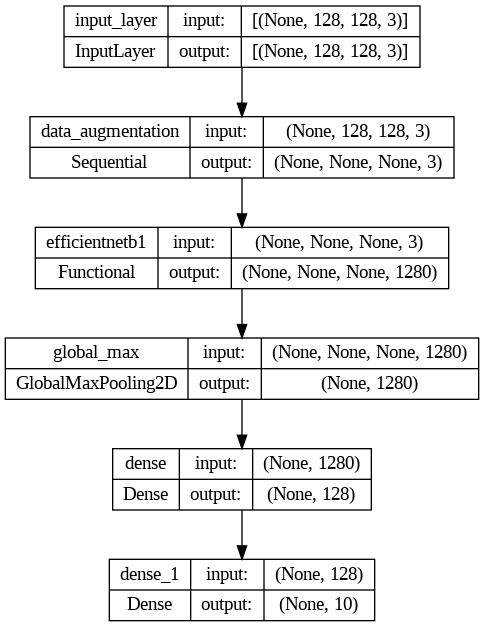

In [11]:
keras.utils.plot_model(model, show_shapes=True)

## Building the Model

In [12]:
# Building the Model
# Inspecting the train_data
print(ds_train)
# Setting up the callbacks
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=5) # if val loss decreases for 5 epochs in a row, stop training
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.25, # multiply the learning rate by 0.2 (reduce by 4x)
                                                 patience=3,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## Check the summary
for no, layer in enumerate(model.layers):
  print(no, layer.trainable)



<_MapDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
0 True
1 False
2 True
3 True
4 True


##  Training model using augmentated dataset

In [13]:
#
######################################################
# Training model using augmentated data
######################################################
#
# %%time
history = model.fit(ds_train, 
                    epochs=100, 
                    steps_per_epoch = len(ds_train), 
                    validation_data = ds_test,
                    validation_steps = len(ds_test), # batchSize,
                    callbacks = [early_stopping, reduce_lr])

#
model.evaluate(ds_test)
# loss: 0.1658 - accuracy: 0.9595



Epoch 1/100
782/782 [==============================] - 98s 102ms/step - loss: 1.0747 - accuracy: 0.6424 - val_loss: 0.5490 - val_accuracy: 0.8201 - lr: 1.0000e-04
Epoch 2/100
782/782 [==============================] - 64s 81ms/step - loss: 0.7387 - accuracy: 0.7520 - val_loss: 0.4790 - val_accuracy: 0.8411 - lr: 1.0000e-04
Epoch 3/100
782/782 [==============================] - 58s 75ms/step - loss: 0.6713 - accuracy: 0.7723 - val_loss: 0.4562 - val_accuracy: 0.8485 - lr: 1.0000e-04
Epoch 4/100
782/782 [==============================] - 59s 76ms/step - loss: 0.6389 - accuracy: 0.7842 - val_loss: 0.4352 - val_accuracy: 0.8551 - lr: 1.0000e-04
Epoch 5/100
782/782 [==============================] - 59s 75ms/step - loss: 0.6125 - accuracy: 0.7931 - val_loss: 0.4246 - val_accuracy: 0.8588 - lr: 1.0000e-04
Epoch 6/100
782/782 [==============================] - 59s 76ms/step - loss: 0.5916 - accuracy: 0.7978 - val_loss: 0.4178 - val_accuracy: 0.8608 - lr: 1.0000e-04
Epoch 7/100
782/782 [======

[0.3657022714614868, 0.8748000264167786]

## Plot of learning curves
- loss, val_loss
- accuracy, val_accuracy

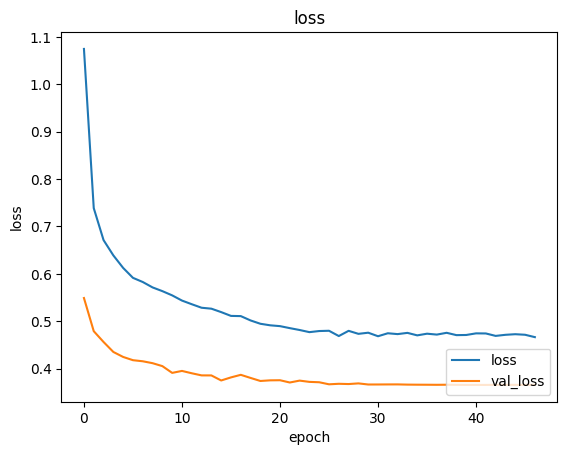

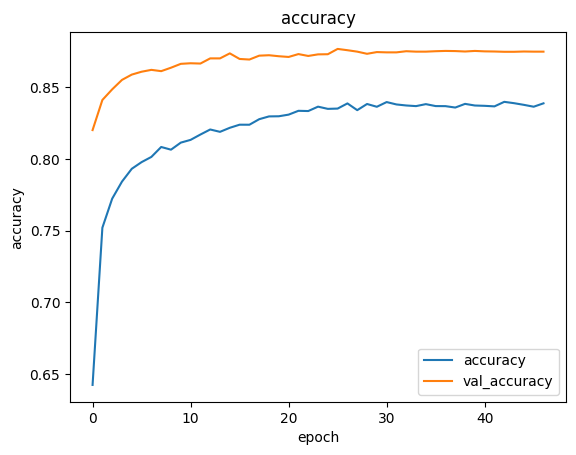

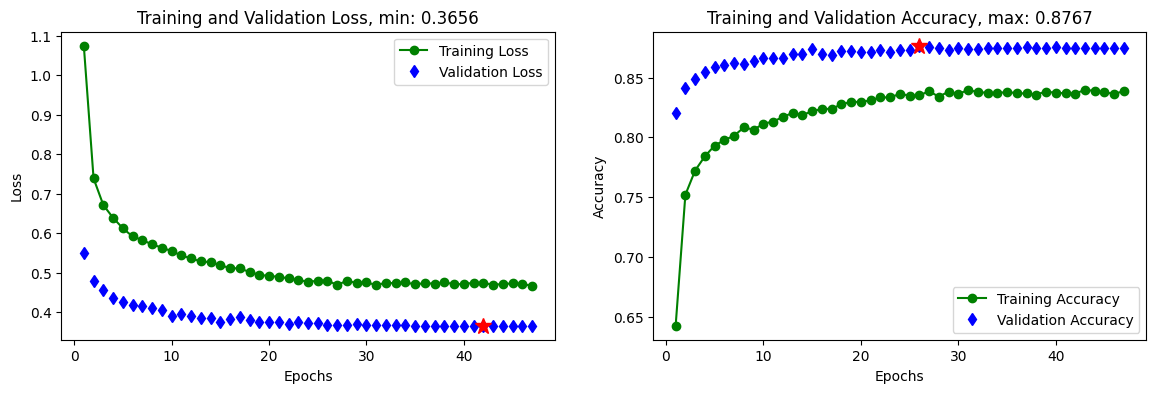

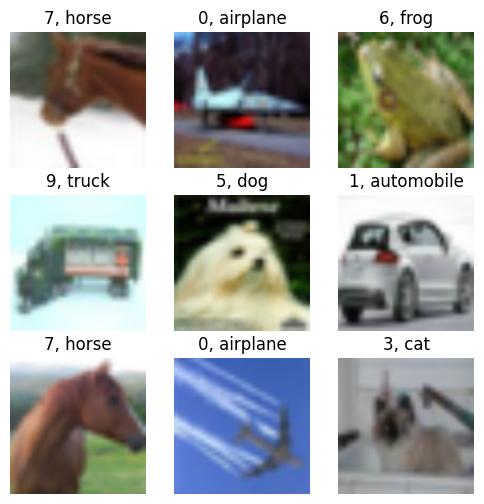

In [14]:
# 손실값을 그래프로 그린다. 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc = 'lower right')
plt.show()

# 정확도를 그래프로 그린다. 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'], loc = 'lower right')
plt.show()

#############################################
# More training graphs
# More graphs of loss and accuracy
# import matplotlib.pyplot as plt
# import numpy as np

history_dict = history.history 
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
for images, labels in ds_test.take(1):  # Make a batch of images & labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()) + ", " + label_names[int(labels[i])])
        plt.axis("off")
plt.show()



## Evaluation using test dataset

In [15]:
y_pred0 = model.predict(ds_test)
y_pred = np.argmax(y_pred0, axis=1)
y_test = [labels.numpy() for _, labels in ds_test.unbatch()]
print("정답=", y_test[0])
print("예측값=", y_pred[0], np.argmax(y_pred0[0]))

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)
# 0.9595

#################################
# Evaluate the model
#################################
model.evaluate(ds_test)  #,y_test)
# loss: 1.1689 - accuracy: 0.6468
# loss: 0.9207 - accuracy: 0.6799    # with dropout: 0.5
# loss: 0.1658 - accuracy: 0.9595    # Transfer learning using EfficientNetB1


157/157 [==============================] - 10s 53ms/step
정답= 7
예측값= 8 8
157/157 [==============================] - 10s 61ms/step - loss: 0.3657 - accuracy: 0.8748


[0.3657022714614868, 0.8748000264167786]

In [18]:
# Save the trained model
model.save('cifar10-TL-EfficientNetB1-ConvNet2.hdf5')

TypeError: ignored